In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [2]:
# date-time parsing function for loading the dataset
# def parser(x):
# 	return datetime.strptime('190'+x, '%Y-%m')

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime(x, '%m/%Y')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


## Data Preprocessing

In [3]:
# load dataset
# series = read_csv('../data/sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv('../data/theft_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head(5)

Date
2001-01-01    5125
2001-02-01    4429
2001-03-01    5024
2001-04-01    4887
2001-05-01    5148
Name: Thefts, dtype: int64

### make data stationary:
It is easier to deal with data that is stationary. Stationary data does not have seasonality or trend and statistical properties such as mean, variance, autocorrelation are all constant over time. Then prediction is simply to learn those unchanging properties of the stationary data. <br>

"I have seen the future and it is very much like the present, only longer."<br>

--Kehlog Albran, The Profit<br>

reference: https://people.duke.edu/~rnau/411diff.htm




In [4]:
# transform data to be stationary
raw_values = series.values
## now raw_values is ndarray, instead of Series
print(raw_values[:5])
print(raw_values.shape)

diff_values = difference(raw_values, 1)
print(diff_values[:5])
print(diff_values.shape)
## now we have 35 data points

[5125 4429 5024 4887 5148]
(210,)
0   -696
1    595
2   -137
3    261
4    138
dtype: int64
(209,)


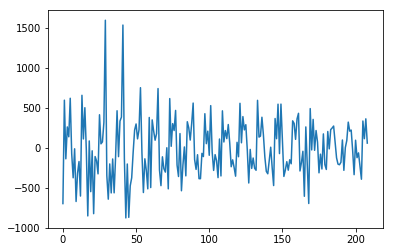

In [5]:
pyplot.plot(diff_values)


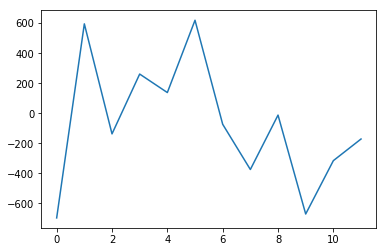

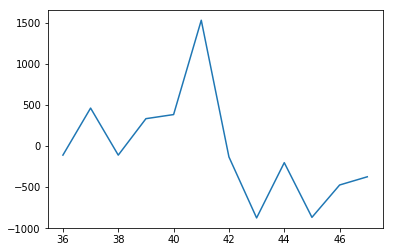

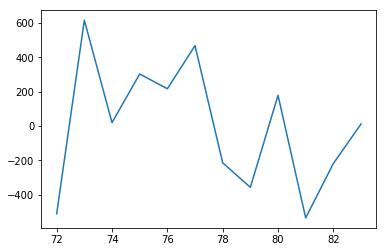

In [6]:
pyplot.plot(diff_values[:12])
pyplot.show()
pyplot.plot(diff_values[36:48])
pyplot.show()
pyplot.plot(diff_values[72:84])
pyplot.show()


### Comment:
The differenced data seems to have some seasonal pattern over the year...

### Make data supervised:
Supervised: use input X to predict y <br>
The data now becomes supervised learning setting: [X, y], with y being the output and X being the input. y is one lag (in this case lag = 1) ahead of X. So the prediction problem now becomes something Neural Network is familiar with: predicting y using X. 

In [7]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
supervised_values[:5,:]

array([[   0., -696.],
       [-696.,  595.],
       [ 595., -137.],
       [-137.,  261.],
       [ 261.,  138.]])

In [8]:
# split data into train and test-sets
train, test = supervised_values[0:-70], supervised_values[-70:]
print(train.shape)
print(test.shape)

(139, 2)
(70, 2)


In [9]:
train, test = supervised_values[:139], supervised_values[139:]
print(train.shape)
print(test.shape)

(139, 2)
(70, 2)


### Scale the data:
The data now is now mapped into [-1,1] <br>
The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [10]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [11]:
print(train_scaled.min())
print(train_scaled.max())
print(train_scaled[:5])

-1.0
0.9999999999999998
[[-0.29092382 -0.85494327]
 [-0.85494327  0.19124797]
 [ 0.19124797 -0.40194489]
 [-0.40194489 -0.07941653]
 [-0.07941653 -0.17909238]]


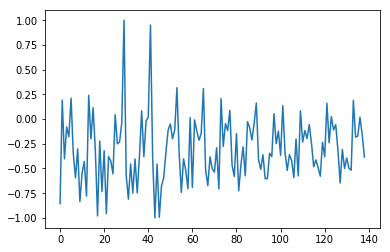

In [12]:
pyplot.plot(train_scaled[:,1])

## Build the model, Train and Predict

### Terminology
#### batch_size: 
the number of samples propogated through the network <br>
##### iteration: 
number of passes (forward+backward), each pass using [bacth_size] number of examples.<br>
##### epoch:
one forward pass and one backward pass of all the training examples

In [13]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
    # Split the data into X (input) and y (output)
	X = X.reshape(X.shape[0], 1, X.shape[1])
    # reshape into the shape [n_samples,timestep_size, n_features]
    # timestep_size: how many time points that you treat as one
    # n_samples: int(total time points / timestep)
    # n_features: the number of separate meaures observed 
    # at the time of observation
    
	model = Sequential()
    
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    # add the first layer: LSTM layer; batch_input_shape specifies the dimension of the input
	model.add(Dense(1))
    # add the "second" layer: it is actually a single cell 
	model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    
	for i in range(nb_epoch):
        # fit: Trains the model for a given number of epochs (iterations on a dataset).
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [14]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
    # 3 dimension? maybe [n_feature, timestep size, n_samples] (not very sure about it)
	yhat = model.predict(X, batch_size=batch_size)
    # Generates output predictions for the input samples.
	return yhat[0,0]

In [15]:
#fit the model
lstm_model = fit_lstm(train_scaled, batch_size = 1, nb_epoch= 5, neurons =4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)


In [16]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
pred_train = lstm_model.predict(train_reshaped, batch_size=1)


In [17]:
pred_train_xy = train_scaled.copy()
pred_train_xy[:,1] = pred_train.reshape(pred_train.shape[0],)

In [18]:
pred_train_xy_inv = scaler.transform(pred_train_xy)

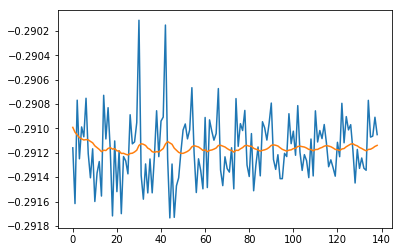

In [19]:
pyplot.plot(pred_train_xy_inv[:,0])
pyplot.plot(pred_train_xy_inv[:,1])

Test RMSE: 284.945


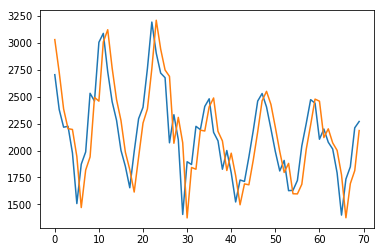

In [21]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size = 1, nb_epoch= 5, neurons =4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 10, X)

	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	#print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-70:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-70:])
pyplot.plot(predictions)
pyplot.show()

In [22]:
def lstm_experiment(batch_size = 1, num_neurons = 4, num_train = 130, rand = False):
    series = read_csv('../data/theft_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    if rand:
        import random
        random.seed(12345)
        rand = random.sample(range(200,30000),series.shape[0])
        series = Series(data = rand, index=series.index)
    
    raw_values = series.values
    diff_values = difference(raw_values, 1)    
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[:num_train], supervised_values[num_train:]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 5, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    #lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

    # report performance
    rmse = sqrt(mean_squared_error(raw_values[num_train+1:], predictions))
    print('Test RMSE: %.3f' % rmse)
    # line plot of observed vs predicted
    pyplot.plot(raw_values[num_train+1:])
    pyplot.plot(predictions)
    pyplot.show()
    return(rmse)

Test RMSE: 10885.727


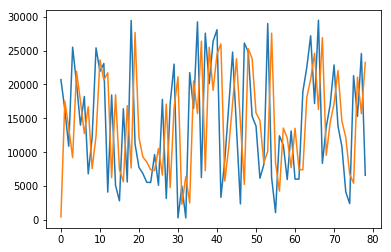

10885.727437772277

In [23]:
lstm_experiment(batch_size=1, num_neurons=8, rand = True)

Test RMSE: 284.401


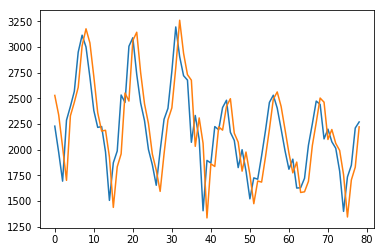

284.40145730264044

In [24]:
lstm_experiment(num_neurons=8, rand = False)

Test RMSE: 289.615


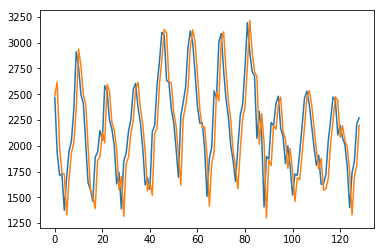

289.61520129317813

In [25]:
lstm_experiment(batch_size=1, num_neurons=8, rand = False, num_train=80)

Test RMSE: 365.935


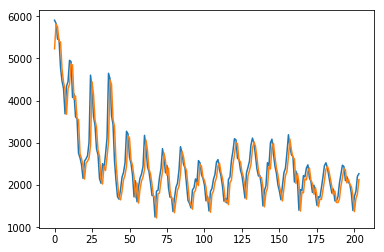

365.9346687190917

In [26]:
lstm_experiment(batch_size=1, num_neurons=8, rand = False, num_train=5)

Test RMSE: 412.453


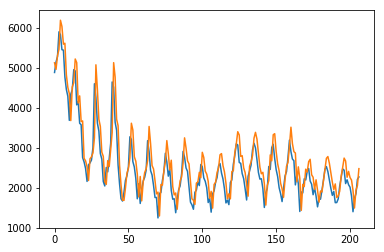

412.452723569895

In [27]:
lstm_experiment(batch_size=1, num_neurons=8, rand = False, num_train=2)

Test RMSE: 373.829


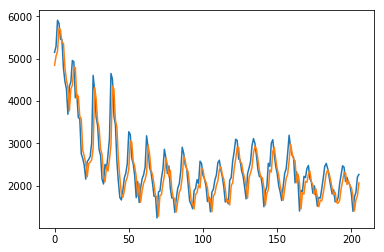

373.82904234734985

In [28]:
lstm_experiment(batch_size=5, num_neurons=8, rand = False, num_train= 3)

Test RMSE: 212.915


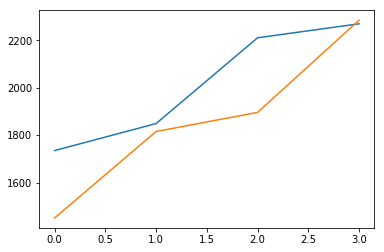

212.91544288465573

In [29]:
lstm_experiment(batch_size=2, num_neurons=8, rand = False, num_train=205)